In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy 
import os
import math
from pathlib import Path
from scipy.ndimage import binary_opening
from skimage.morphology import disk


/home/laura/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Read and visualize raw images
Using [rawpy](https://letmaik.github.io/rawpy/api/rawpy.RawPy.html) library to read the pixel values.

The camera should be 5184x3456 pixels but the raw image has 5202x3464

In [3]:
# use rawpy library to read the pixel intensity values of the raw image

def process_raw(file_path):
    raw = rawpy.imread(file_path)
    black_level = raw.black_level_per_channel # black level offset 
    raw_image = raw.raw_image_visible.astype(np.float32) # raw pixel intensity value
    raw_image = raw_image - black_level[0] # apply black level correction
    raw_image = np.clip(raw_image, 0, None) # avoid negavative values
    return raw_image

In [4]:
# crop picture by taking bounds of non-black pixels, set a threshold for non-black on the normalized pixel values
# use binary_opening to remove bright spots in the background
def crop_image(raw_image, mask_treshold = 0.005, mask_size = 5):
    raw_image_norm = raw_image / np.max(raw_image)
    mask = raw_image_norm > mask_treshold
    cleaned_mask = binary_opening(mask, structure=disk(mask_size))
    non_black_pixels = np.argwhere(cleaned_mask)
    y_min, x_min = np.min(non_black_pixels, axis = 0)
    y_max, x_max = np.max(non_black_pixels, axis = 0)
    cropped_image = raw_image[y_min-10:y_max+10, x_min-10:x_max+10] 
    return cropped_image, cleaned_mask[y_min-10:y_max+10, x_min-10:x_max+10] 

In [5]:
cm = 0.393701

# Plot image in black and white
def display_image(raw_image, title = None, axis = None):
    raw_image_norm = raw_image / np.max(raw_image)
    if axis == None:
        fig = plt.figure()
        axis = fig.add_subplot(1, 1, 1)
    axis.imshow(raw_image_norm, cmap='gray')
    axis.set_title(title)
    axis.axis("off")

# Visualize the brightest spot of the image
def display_brightest_spot(raw_image, title = None, axis = None):
    raw_image_norm = raw_image / np.max(raw_image)
    max_index = np.argmax(raw_image_norm)
    y_max, x_max = np.unravel_index(max_index, raw_image.shape)
    if axis == None:
        fig = plt.figure()
        axis = fig.add_subplot(1, 1, 1)
    axis.imshow(raw_image_norm, cmap='gray')
    axis.scatter(x_max, y_max, marker = 'x', color = 'red')
    axis.set_title(title)
    axis.axis("off")


## Intensity Profile

[]

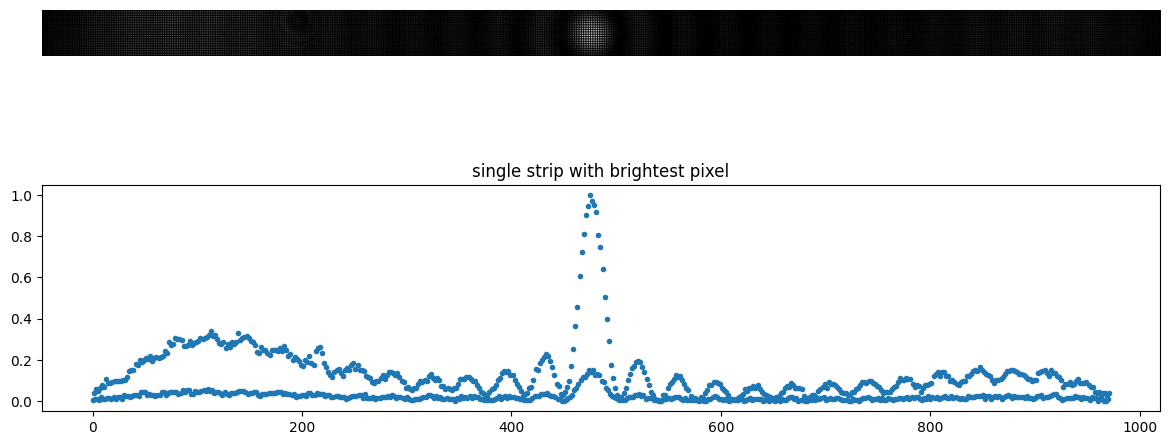

In [26]:
# as a reference we use the IMG_1986 with F ~ 15 
raw_image = process_raw("/media/laura/Data/Sync/ETH/FS2025/PPLUS/experiments/1-arago/experiment-images/Fresnel-dependency/IMG_1786.CR2")
cropped_image, _ = crop_image(raw_image, 0.004, 3) # crop image
cropped_image_norm = cropped_image / np.max(cropped_image)
y_max, x_max = np.unravel_index(np.argmax(cropped_image), cropped_image.shape) # focus on the cutout with the brithest intensity

fig = plt.figure(figsize=(30*cm, 20*cm))

ax1 = fig.add_subplot(3, 1, 1)
display_image(cropped_image_norm[415:455], title = None, axis=ax1)

central = cropped_image[y_max]
central_norm = cropped_image_norm[y_max]
average = np.mean(cropped_image[415:455], axis = 0)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(range(len(central_norm)), central_norm, '.')
ax2.set_title("single strip with brightest pixel")

# ax3 = fig.add_subplot(3, 1, 3)
# ax3.plot(range(len(central_norm)), average, '.')
# ax3.set_title("Average of 40 central pixels")

plt.tight_layout()
plt.plot()

## Fresnel number vs Arago Spot Intensity

In [39]:
# set-up values
d = 2.5 * 1e-3 # ball diameter:  2.5 mm
ball_pos = 25 * 1e-2 # position of the ball on the railings: 25 cm
laser = 632.8 * 1e-9 # wavelength of the red laser: 
err = 1 * 1e-3 # error on railings measuraments: 1 mm 

# compute fresnel number
def get_F(L, laser = 632.8 * 1e-9, d = 2.5 * 1e-3):
    F = d**2 / (L * laser)
    return F

# read camera position measuraments
pardir = Path.cwd().parent
file = os.path.join(pardir, "measuraments/measuraments.txt")
data = np.loadtxt(file, comments='#', delimiter=',')
camera_pos = data[:, 0] * 1e-2
Fresnel_number = get_F(camera_pos - ball_pos)

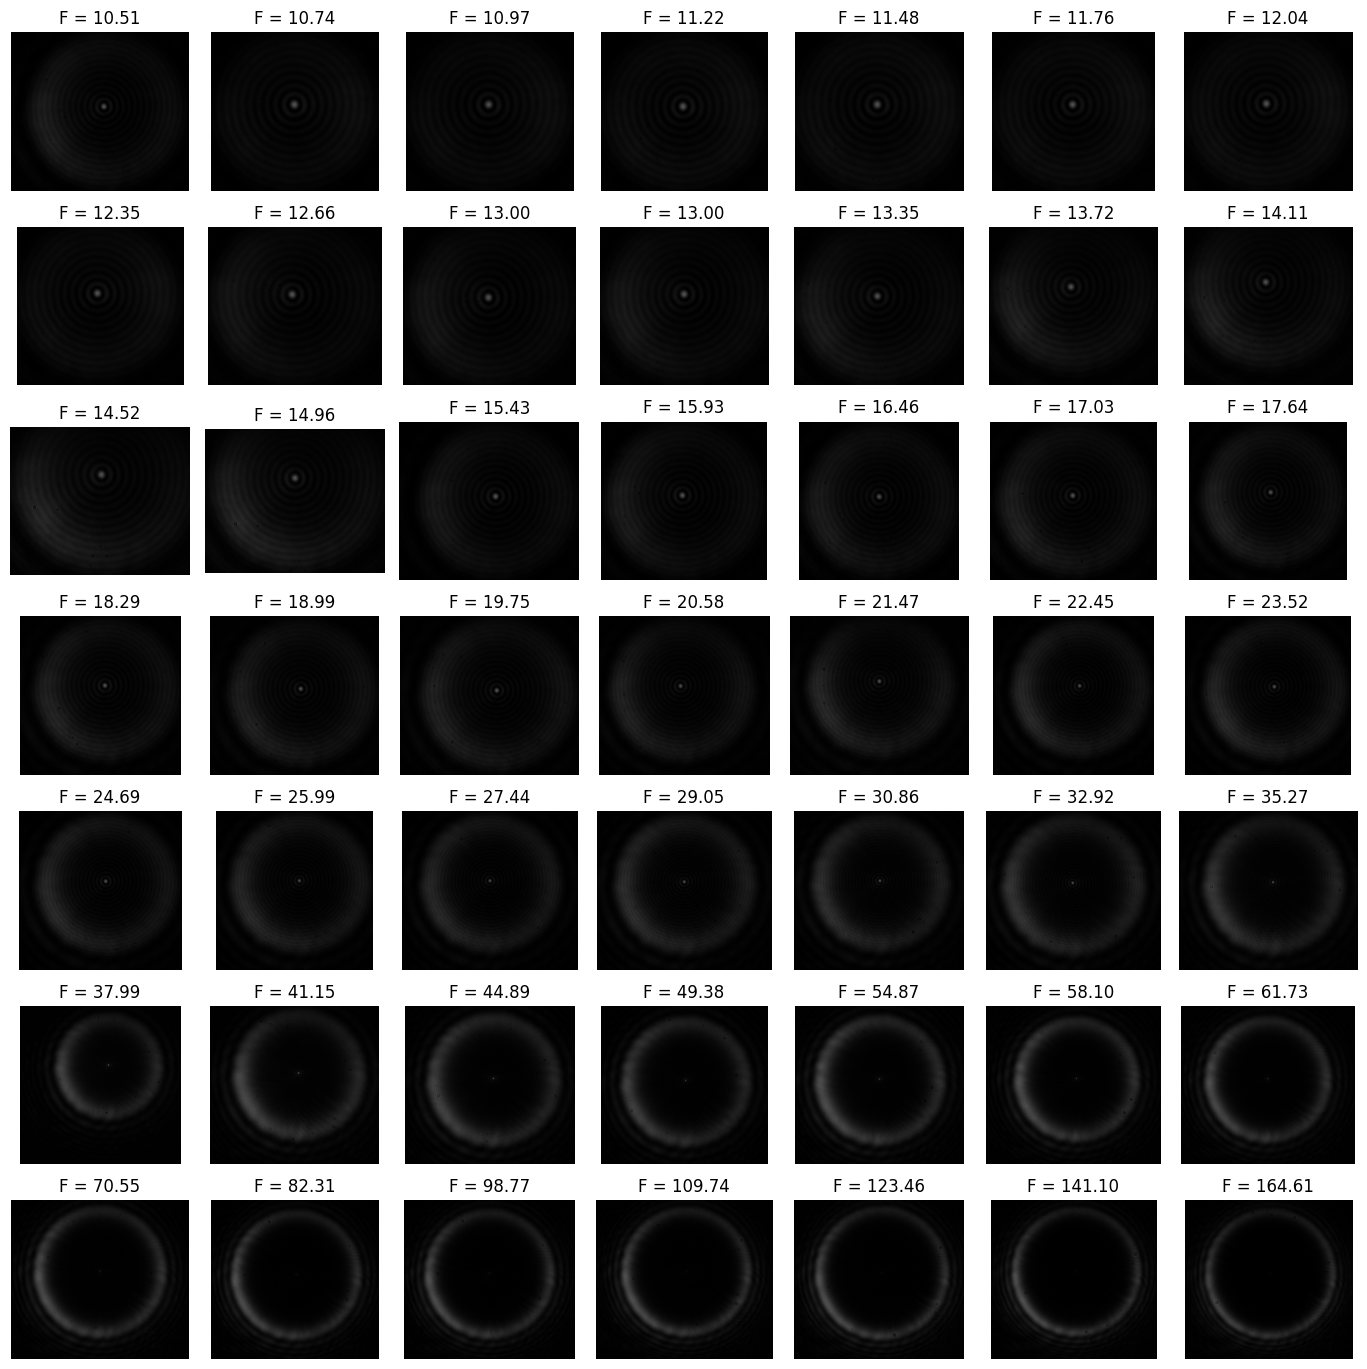

In [ ]:
# print all images
pardir = Path.cwd().parent
dir = os.path.join(pardir, "experiment-images/Fresnel-dependency")
N = len(os.listdir(dir))
rows = math.ceil(np.sqrt(N))
cols = math.ceil(N/rows)
size = 5 * cm
fig = plt.figure(figsize=(cols*size, rows*size))
ax = fig.subplots(rows, cols)
ax = ax.flatten()

for i, file_name in enumerate(os.listdir(dir)):
    file_path = os.path.join(dir, file_name)
    raw_image = process_raw(file_path)
    cropped_image, _ = crop_image(raw_image, 0.004, 3)
    distance = camera_pos - ball_pos
    title = f'F = {Fresnel_number[i]:.2f}'
    display_image(cropped_image, title, ax[i])
    
fig.savefig("plots/Fresnel-grid.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

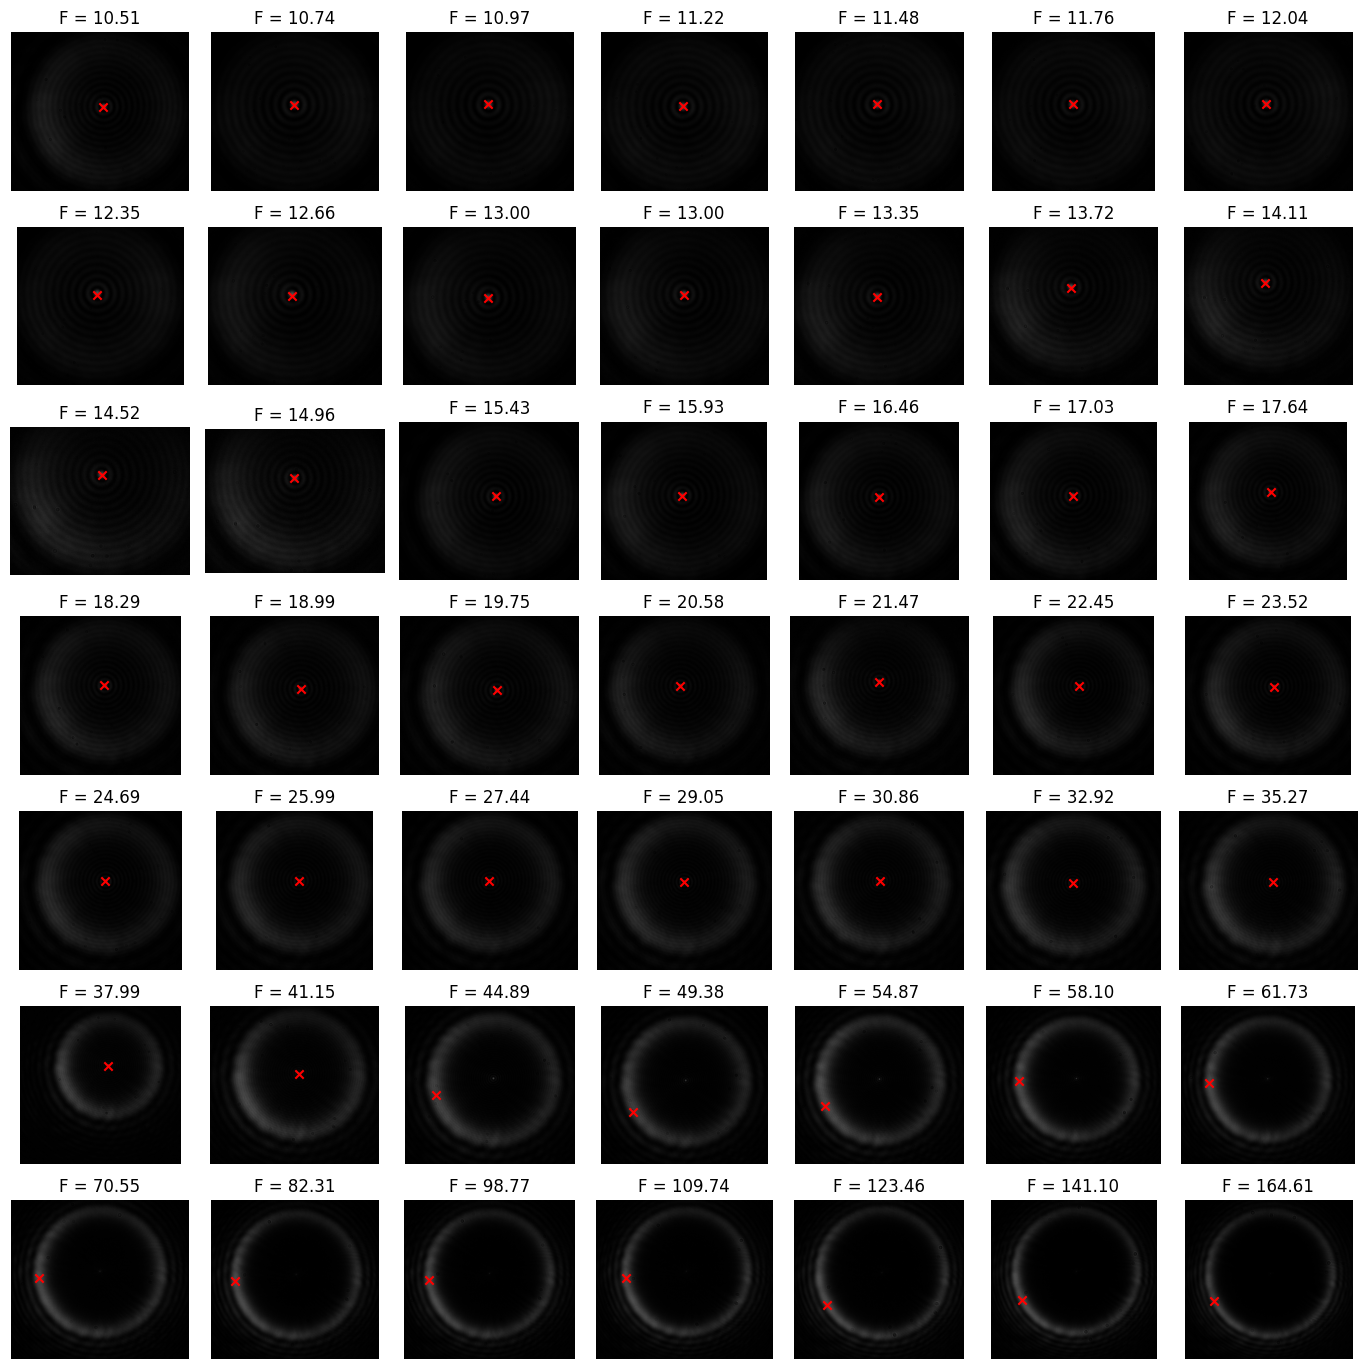

In [49]:
# print all images
pardir = Path.cwd().parent
dir = os.path.join(pardir, "experiment-images/Fresnel-dependency")
N = len(os.listdir(dir))
rows = math.ceil(np.sqrt(N))
cols = math.ceil(N/rows)
size = 5 * cm
fig = plt.figure(figsize=(cols*size, rows*size))
ax = fig.subplots(rows, cols)
ax = ax.flatten()

for i, file_name in enumerate(os.listdir(dir)):
    file_path = os.path.join(dir, file_name)
    raw_image = process_raw(file_path)
    cropped_image, _ = crop_image(raw_image, 0.004, 3)
    distance = camera_pos - ball_pos
    title = f'F = {Fresnel_number[i]:.2f}'
    display_brightest_spot(cropped_image, title, ax[i])
    
fig.savefig("plots/Fresnel-grid-brightest-spot.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()